# Generating Faces model training

**The goal is to improve the learning speed of anime character face generation using a pretrained VGG16 convolutional neural network model**

Here's the original approach without the use of transfer learning:
https://www.kaggle.com/code/nassimyagoub/gan-anime-faces

VGG16 is a convolutional neural network model proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper "Very Deep Convolutional Networks for Large-Scale Image Recognition". The model achieves 92.7% top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes.


## Importing libraries and loading data

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, Reshape, Flatten, Input, Conv2D, MaxPooling2D, Activation, Dropout, Conv2DTranspose, BatchNormalization
from tensorflow.keras.applications import VGG16


In [12]:
def list_images(basePath, contains=None):
    # return the set of files that are valid
    return list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp"), contains=contains)

def list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp"), contains=None):
    # loop over the directory structure
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # loop over the filenames in the current directory
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue

            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()

            # check to see if the file is an image and should be processed
            if ext.endswith(validExts):
                # construct the path to the image and yield it
                imagePath = os.path.join(rootDir, filename).replace(" ", "\\ ")
                yield imagePath
                
def load_images(directory='', size=(64,64)):
    images = []
    labels = []  # Integers corresponding to the categories in alphabetical order
    label = 0
    
    imagePaths = list(list_images(directory))
    
    for path in tqdm.tqdm(imagePaths):
        
        if not('OSX' in path):
        
            path = path.replace('\\','/')
            print(path)
            image = cv2.imread(path) #Reading the image with OpenCV
            image = cv2.resize(image,size) #Resizing the image, in case some are not of the same size

            images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    return images

In [13]:
# images=load_images('/content/drive/MyDrive/DL_models/anime_ds_full/images')

In [14]:
import pickle

# File path to stored pickle data
file_path = '/content/drive/MyDrive/DL_models/images.pkl'

# Load the images list from the pickle file
with open(file_path, 'rb') as file:
    images = pickle.load(file)

print("Images loaded from the pickle file.")

Images loaded from the pickle file.


## Looking at some images

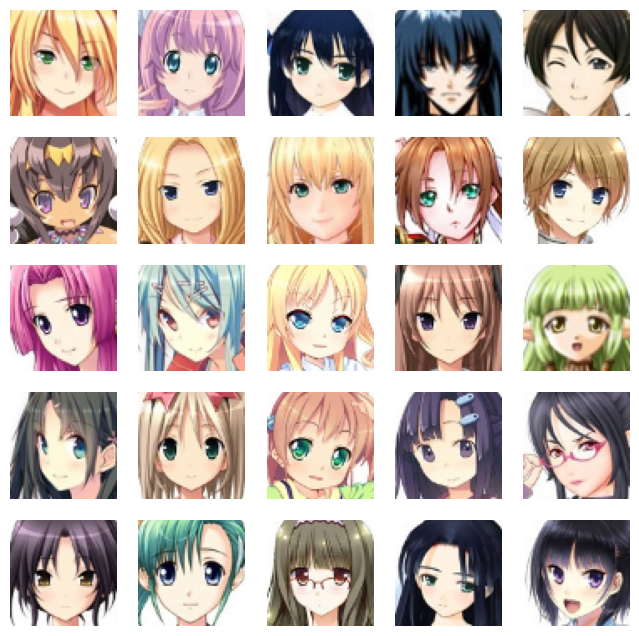

In [15]:
_,ax = plt.subplots(5,5, figsize = (8,8)) 
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(images[5*i+j])
        ax[i,j].axis('off')

## Generative Adversarial Networks

The objective of a GAN is to train a data generator in order to imitate a given dataset.
A GAN is similar to a zero sum game between two neural networks, the generator of data and a discriminator, trained to recognize original data from fakes created by the generator.

## Creating the GAN

We incorporated a pretrained VGG16 model into the discriminator model and added the capability to continue training from the epoch at which the model was saved. This allows us to leverage the knowledge learned by the VGG16 model and further enhance the discriminator's performance in our GAN-based anime character face generation. The pretrained VGG16 model provides a strong backbone for feature extraction, improving the discriminator's ability to distinguish between real and generated images. Additionally, the ability to continue training from a saved checkpoint allows us to fine-tune the model and potentially achieve even better results over time.

In [16]:
class GAN():
    def __init__(self, load_model=False, start_epoch=0):
        self.img_shape = (64, 64, 3)
        self.start_epoch = start_epoch
        self.noise_size = 100

        optimizer = Adam(0.0002,0.5)

        # Check if models need to be loaded
        if load_model:
            # load last saved models
            self.generator = tf.keras.models.load_model("/content/drive/MyDrive/DL_models/vgg/generator_%d" % start_epoch)
            self.discriminator = tf.keras.models.load_model("/content/drive/MyDrive/DL_models/vgg/discriminator_%d" % start_epoch)
        else:
            self.discriminator = self.build_discriminator()
            self.generator = self.build_generator()

        self.discriminator.compile(loss='binary_crossentropy', 
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        self.combined = Sequential()
        self.combined.add(self.generator)
        self.combined.add(self.discriminator)
        
        self.discriminator.trainable = False
        
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        self.combined.summary()
        
    # Creating the generator, the large kernels in the convolutional layers allow the network to create complex structures.
    def build_generator(self):
        epsilon = 0.00001 # Small float added to variance to avoid dividing by zero in the BatchNorm layers.
        noise_shape = (self.noise_size,)
        
        model = Sequential()
        
        model.add(Dense(4*4*512, activation='linear', input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Reshape((4, 4, 512)))
        
        model.add(Conv2DTranspose(512, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(256, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(128, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(64, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(3, kernel_size=[4,4], strides=[1,1], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))

        # Standard activation for the generator of a GAN
        model.add(Activation("tanh"))
        
        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    from keras.applications import VGG16

    def build_discriminator(self):

        vgg = VGG16(weights='imagenet', include_top=False, input_shape=self.img_shape)

        # Freeze the layers
        for layer in vgg.layers:
            layer.trainable = False

        model = Sequential()
        model.add(vgg)

        model.add(Flatten())
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)


    def train(self, epochs, batch_size=128, metrics_update=50, save_images=100, save_model=2000):

        X_train = np.array(images)
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5

        half_batch = int(batch_size / 2)
        
        mean_d_loss=[0,0]
        mean_g_loss=0

        for epoch in tqdm(range(self.start_epoch, epochs)):
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, self.noise_size))
            gen_imgs = self.generator.predict(noise)

            # Training the discriminator
            self.discriminator.trainable = True
            self.discriminator.compile(loss='binary_crossentropy', 
                                      optimizer=Adam(0.0002,0.5),
                                      metrics=['accuracy'])
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Training the generator
            self.discriminator.trainable = False
            self.combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002,0.5))
            noise = np.random.normal(0, 1, (batch_size, self.noise_size))
            valid_y = np.array([1] * batch_size)
            g_loss = self.combined.train_on_batch(noise, valid_y)
                
            # We print the losses and accuracy of the networks every 200 batches mainly to make sure the accuracy of the discriminator
            # is not stable at around 50% or 100% (which would mean the discriminator performs not well enough or too well)
            if epoch % metrics_update == 0:
                    print ("%d [Discriminator loss: %f, acc.: %.2f%%] [Generator loss: %f]" % (epoch, mean_d_loss[0]/metrics_update, 100*mean_d_loss[1]/metrics_update, mean_g_loss/metrics_update))
                    mean_d_loss=[0,0]
                    mean_g_loss=0
                
            # Saving 25 images
            if epoch % save_images == 0:
                self.save_images(epoch)
                
            # We save the architecture of the model, the weights and the state of the optimizer
            # This way we can restart the training exactly where we stopped
            if epoch % save_model == 0:
                self.generator.save("/content/drive/MyDrive/DL_models/vgg/generator_%d" % epoch)
                self.discriminator.save("/content/drive/MyDrive/DL_models/vgg/discriminator_%d" % epoch)

          # Saving 25 generated images to have a representation of the spectrum of images created by the generator
    def save_images(self, epoch):
        noise = np.random.normal(0, 1, (25, self.noise_size))
        gen_imgs = self.generator.predict(noise)
        
        # Rescale from [-1,1] into [0,1]
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(5,5, figsize = (8,8))

        for i in range(5):
            for j in range(5):
                axs[i,j].imshow(gen_imgs[5*i+j])
                axs[i,j].axis('off')

        plt.show()
        
        fig.savefig("/content/drive/MyDrive/DL_models/animeGenerated/Faces_%d.png" % epoch)
        plt.close()


## Training the networks

In [17]:
#This folder will contain the images generated during the training
!mkdir "/content/drive/MyDrive/DL_models/animeGenerated"

mkdir: cannot create directory ‘/content/drive/MyDrive/DL_models/animeGenerated’: File exists


### Things to keep in mind while training a GAN

**In the case of a GAN, cost functions may not converge using gradient descent.**
<br/>Training a GAN is very different from training a regular neural network. The main difference come from the fact that the discriminator also evolves.
Therefore, the cost function that the generator tries to minimize is also evolving.

**The discriminator must be powerful enough to recognize small differences between the real and fake images.**
<br/>If the discriminator does not perform well, the generator cannot progress.
If the accuracy of the discriminator stabilizes near 50%, the generator already tricks the discriminator well and does not need to improve.

**The two networks must progress in synergy to avoid a diminished gradient during the training of the generator.**
<br/>The discriminator must not be too effective at the beginning, if it is, the generator will not progress until it randomly creates a very convincing image.

We want to avoid **mode collapse** which is when the generator creates the same output no matter the input noise.
It leads to an overfitting from the discriminator which remembers the features of the fake, no matter how convincing it is.

**A high learning rate creates a situation in which both networks overfit to exploit short term opponent weaknesses.**
<br/>The **learning rate** of the optimizer must be carefully chosen.
A high learning rate prevents the generator from reaching a certain level of details, it prevents the convergence.
It also leads to an overfitting from the discriminator which recognizes the most recent features made by the generator but forgets the previous ones.

### Training session

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 64, 64, 3)         7782083   
                                                                 
 model (Functional)          (None, 1)                 15895361  
                                                                 
Total params: 23,677,444
Trainable params: 7,780,163
Non-trainable params: 15,897,281
_________________________________________________________________


  0%|          | 0/14701 [00:00<?, ?it/s]

1/1 [==============================] - 1s 530ms/step


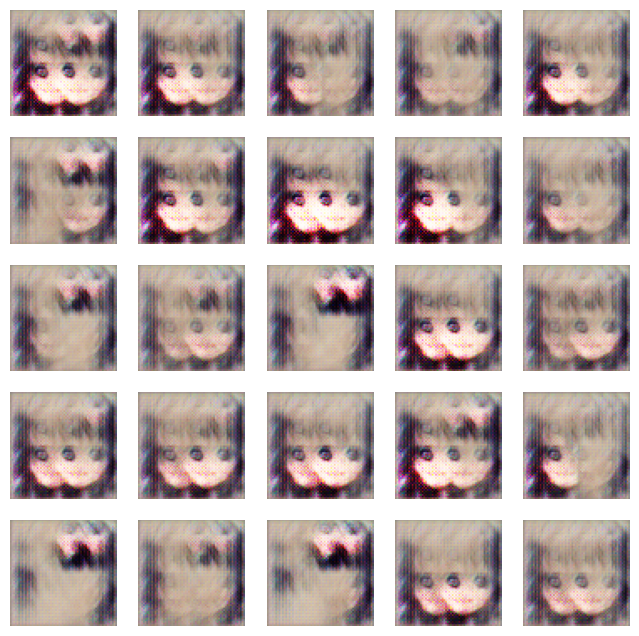

  0%|          | 1/14701 [00:49<201:02:06, 49.23s/it]

4/4 [==============================] - 0s 26ms/step


  0%|          | 2/14701 [01:01<111:07:09, 27.21s/it]

4/4 [==============================] - 0s 26ms/step


  0%|          | 3/14701 [01:11<80:14:58, 19.66s/it] 

4/4 [==============================] - 0s 26ms/step


  0%|          | 4/14701 [01:22<66:30:56, 16.29s/it]

4/4 [==============================] - 0s 27ms/step


  0%|          | 5/14701 [01:33<57:45:19, 14.15s/it]

4/4 [==============================] - 0s 26ms/step


  0%|          | 6/14701 [01:45<55:33:34, 13.61s/it]

4/4 [==============================] - 0s 28ms/step


  0%|          | 7/14701 [02:00<56:36:52, 13.87s/it]

4/4 [==============================] - 0s 31ms/step


  0%|          | 8/14701 [02:12<54:25:37, 13.34s/it]

4/4 [==============================] - 0s 26ms/step


  0%|          | 9/14701 [02:26<54:51:11, 13.44s/it]

4/4 [==============================] - 0s 26ms/step


  0%|          | 10/14701 [02:39<54:44:18, 13.41s/it]

4/4 [==============================] - 0s 26ms/step


  0%|          | 11/14701 [02:51<53:05:25, 13.01s/it]

4/4 [==============================] - 0s 26ms/step


  0%|          | 12/14701 [03:02<50:43:08, 12.43s/it]

4/4 [==============================] - 0s 27ms/step


  0%|          | 13/14701 [03:13<49:11:52, 12.06s/it]

4/4 [==============================] - 0s 26ms/step


  0%|          | 14/14701 [03:23<46:46:29, 11.47s/it]

4/4 [==============================] - 0s 26ms/step


  0%|          | 15/14701 [03:35<46:49:15, 11.48s/it]

4/4 [==============================] - 0s 27ms/step


  0%|          | 16/14701 [03:46<46:46:54, 11.47s/it]

4/4 [==============================] - 0s 26ms/step


  0%|          | 17/14701 [03:59<48:12:12, 11.82s/it]

4/4 [==============================] - 0s 26ms/step


  0%|          | 18/14701 [04:10<47:10:22, 11.57s/it]

4/4 [==============================] - 0s 26ms/step


  0%|          | 19/14701 [04:21<46:48:01, 11.48s/it]

4/4 [==============================] - 0s 27ms/step


  0%|          | 20/14701 [04:32<45:33:26, 11.17s/it]

4/4 [==============================] - 0s 27ms/step


  0%|          | 21/14701 [04:44<46:27:25, 11.39s/it]

4/4 [==============================] - 0s 26ms/step


  0%|          | 22/14701 [04:56<47:25:34, 11.63s/it]

4/4 [==============================] - 0s 26ms/step


  0%|          | 23/14701 [05:09<49:36:29, 12.17s/it]

4/4 [==============================] - 0s 26ms/step


  0%|          | 24/14701 [05:21<48:45:47, 11.96s/it]

4/4 [==============================] - 0s 26ms/step


  0%|          | 25/14701 [05:32<47:42:37, 11.70s/it]

4/4 [==============================] - 0s 26ms/step


  0%|          | 26/14701 [05:43<46:55:22, 11.51s/it]

4/4 [==============================] - 0s 35ms/step


  0%|          | 27/14701 [05:54<46:04:21, 11.30s/it]

4/4 [==============================] - 0s 26ms/step


  0%|          | 28/14701 [06:05<46:01:27, 11.29s/it]

4/4 [==============================] - 0s 26ms/step


  0%|          | 29/14701 [06:18<48:02:11, 11.79s/it]

4/4 [==============================] - 0s 28ms/step


  0%|          | 30/14701 [06:29<47:42:18, 11.71s/it]

4/4 [==============================] - 0s 26ms/step


  0%|          | 31/14701 [06:40<46:54:44, 11.51s/it]

4/4 [==============================] - 0s 26ms/step


  0%|          | 32/14701 [06:52<46:29:53, 11.41s/it]

4/4 [==============================] - 0s 29ms/step


In [ ]:
gan = GAN(load_model=True, start_epoch=300)
gan.train(epochs=15001, batch_size=256, metrics_update=250, save_images=50, save_model=50)